<a href="https://colab.research.google.com/github/sllvers/projects/blob/main/TenzinYega.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Defining**

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import numpy as np
import matplotlib.pyplot as plt
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import zipfile
import os
import shutil
from PIL import Image, UnidentifiedImageError
import pandas as pd



**LOAD DATASET**


In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip


--2024-08-26 03:52:31--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.218.207, 142.251.31.207, 142.251.18.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.218.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  28.5MB/s    in 2.3s    

2024-08-26 03:52:33 (28.5 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

**RESIZE**

In [ ]:
# Define the directories for train and validation sets
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Function to resize images
def resize_images(directory, target_size=(150, 150)):
    for folder in ['cats', 'dogs']:
        folder_path = os.path.join(directory, folder)
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            if filename.endswith('.jpg'):
                with Image.open(file_path) as img:
                    img = img.resize(target_size)
                    img.save(file_path)

# Resize images in train and validation directories
resize_images(train_dir)
resize_images(validation_dir)

In [ ]:
# Function to filter out corrupted images
def filter_corrupted_images(directory):
    for folder in ['cats', 'dogs']:
        folder_path = os.path.join(directory, folder)
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            if filename.endswith('.jpg'):
                try:
                    with Image.open(file_path) as img:
                        img.verify()  # Verify that it is an image
                except (IOError, SyntaxError, UnidentifiedImageError) as e:
                    print(f'Removing corrupted image: {file_path}')
                    os.remove(file_path)

# Filter corrupted images in train and validation directories
filter_corrupted_images(os.path.join('/tmp/cats_and_dogs_filtered', 'train'))
filter_corrupted_images(os.path.join('/tmp/cats_and_dogs_filtered', 'validation'))

**GENERALIZE**

In [ ]:
# ImageDataGenerator for training with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# ImageDataGenerator for validation (without augmentation)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Load and preprocess training images
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

# Load and preprocess validation images
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


**MODEL**

In [ ]:
model = Sequential()

# Convolutional layer and max pooling
model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flattening the layers
model.add(Flatten())

# Fully connected layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))  # Dropout to prevent overfitting
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


**TRAIN**

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=2000 // 32,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=800 // 32)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 22s 234ms/step - accuracy: 0.4999 - loss: 0.7059 - val_accuracy: 0.5612 - val_loss: 0.6895
Epoch 2/10
 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5000 - loss: 0.7032

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5000 - loss: 0.7032 - val_accuracy: 0.5550 - val_loss: 0.6855
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 32s 181ms/step - accuracy: 0.5574 - loss: 0.6910 - val_accuracy: 0.5850 - val_loss: 0.6722
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5312 - loss: 0.7066 - val_accuracy: 0.5900 - val_loss: 0.6757
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 20s 182ms/step - accuracy: 0.6014 - loss: 0.6689 - val_accuracy: 0.6125 - val_loss: 0.6566
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7500 - loss: 0.6028 - val_accuracy: 0.6850 - val_loss: 0.6115
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 19s 176ms/step - accuracy: 0.6226 - loss: 0.6560 - val_accuracy: 0.6400 - val_loss: 0.6491
Epoch 8/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6875 - loss: 0.6280 - val_accuracy: 0.6050 - val_loss: 0.6679
Epoch 9/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 20s 179ms/step - accuracy: 0.6415 - loss: 0.6439 - val_accuracy: 0.6212 - val_lo

**EVALUATE**

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6202 - loss: 0.6599
Validation Loss: 0.6373539566993713
Validation Accuracy: 0.640999972820282


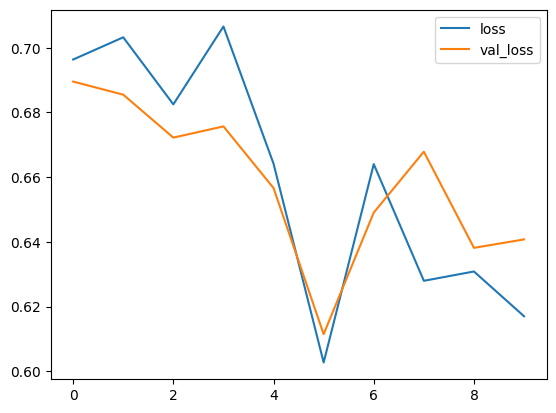

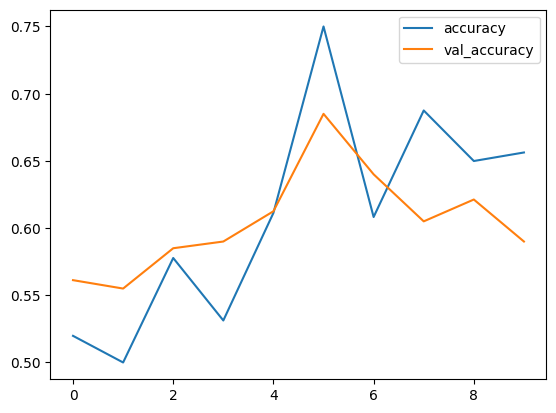

In [ ]:
# Evaluate the model on validation data
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()
plt.show()

**SAVING THE MODEL**

In [ ]:
model.save('cat_dog_classifier.h5')


NameError: name 'model' is not defined

**PREDICTION**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


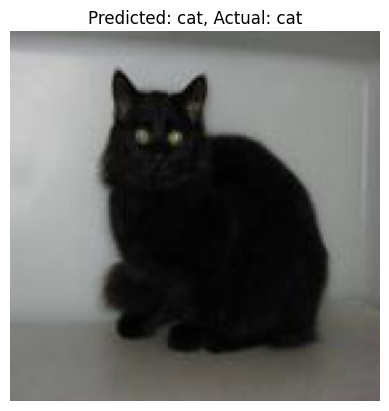

Prediction: cat, Actual: cat


In [ ]:
def preprocess_image(image_path, target_size=(150, 150)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale the image
    return img_array

def predict_random_image(model, base_dir):
    categories = ['cats', 'dogs']
    category = random.choice(categories)
    category_dir = os.path.join(base_dir, 'validation', category)

    # Select a random image from the selected category
    image_filename = random.choice(os.listdir(category_dir))
    image_path = os.path.join(category_dir, image_filename)

    # Preprocess the image
    img_array = preprocess_image(image_path)

    # Make prediction
    prediction = model.predict(img_array)
    prediction_label = 'dog' if prediction[0] > 0.5 else 'cat'

    # Display the image and prediction
    img = load_img(image_path)
    plt.imshow(img)
    plt.title(f'Predicted: {prediction_label}, Actual: {category[:-1]}')
    plt.axis('off')
    plt.show()

    print(f'Prediction: {prediction_label}, Actual: {category[:-1]}')

# Base directory for the dataset
base_dir = '/tmp/cats_and_dogs_filtered'

# Randomly select an image and make prediction
predict_random_image(model, base_dir)
